# DATA INGESTION PHASE


Now let's read the items into the relevant data frames. Items were pre pickled for faster use. We will work on both the train and the test sets as the data preperation is identical for both.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime , timedelta
import numpy as np
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import OrderedDict
import calendar

In [2]:
df_train=pd.read_pickle('C:\\Users\\DELL\\Desktop\\Ronen\\R\\YellowRoad\\Project\\carInsurance_train.pi')
 # reading the first 5 rows of the dataframe
df_train.head(5)
df_test=pd.read_pickle('C:\\Users\\DELL\\Desktop\\Ronen\\R\\YellowRoad\\Project\\carInsurance_test.pi')
df_train.head()



,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


# Data Exploration Stage

Now that the data frames have been ingested properly, we would like to explore the data a little bit. Since this is a classification problem, let's visualize the distributions of some critical features in this data. 

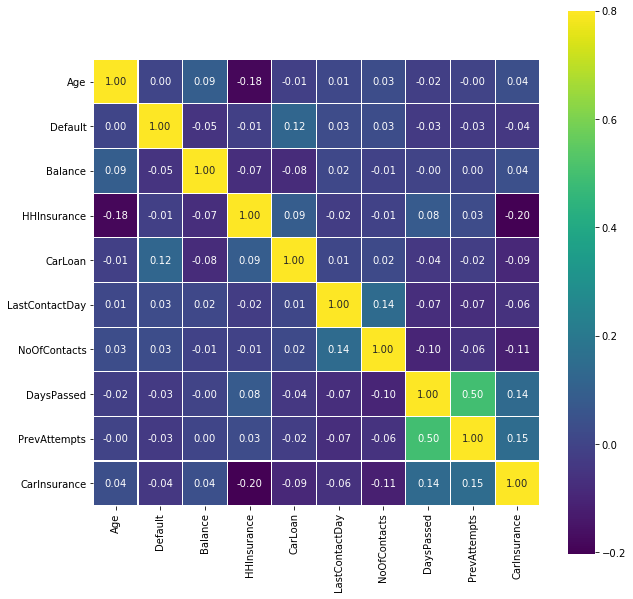

In [3]:
# Let's find the correlations between our features
%matplotlib inline
corr=df_train.corr()
colormap=plt.cm.viridis
corr=corr.drop(['Id'],axis=1).drop(['Id'],axis=0)
plt.figure(figsize=(10,10))
sns.heatmap(corr,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)


We see that the parameters are not so correlated. There is a slight correlation between the previous atttempts and the days that passed, but at 50% I will leave them as is and think of different conclusions

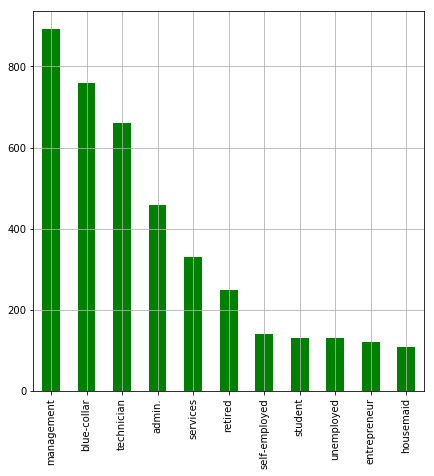

In [4]:
%matplotlib inline
df_train['Job'].value_counts().plot(kind='bar',figsize=(7,7),color='g',grid=True) # Plotting the distribution of jobs of the addressed people


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BBB0358>]], dtype=object)

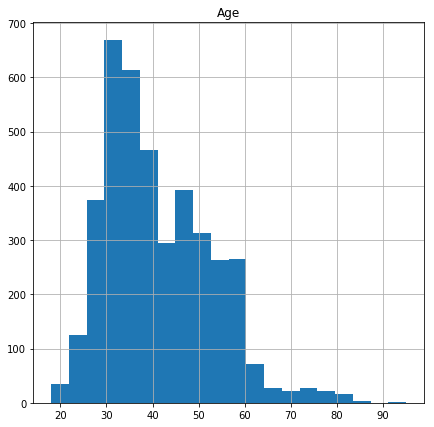

In [5]:
# Let's see the distribution of ages that are addressed
df_train.hist(column='Age',figsize=(7,7),bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B9D7630>]], dtype=object)

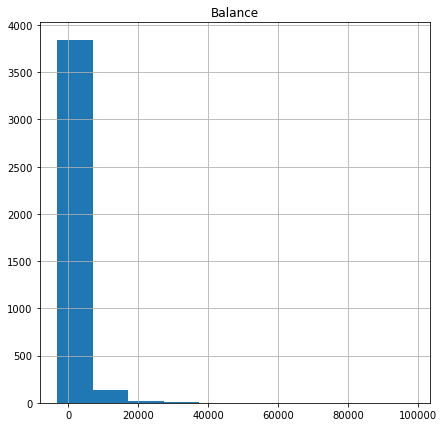

In [6]:
# Let's see the distribution of ages that are addressed
df_train.hist(column='Balance',figsize=(7,7),bins=10)

By Looking at the histogram above, we can see that the balance is more condensed, so we would like to check what is the feature's descriptive statistics

In [7]:
# Checking the descriptive statistics on the Balance values
df_train['Balance'].describe()


count     4000.000000
mean      1532.937250
std       3511.452489
min      -3058.000000
25%        111.000000
50%        551.500000
75%       1619.000000
max      98417.000000
Name: Balance, dtype: float64

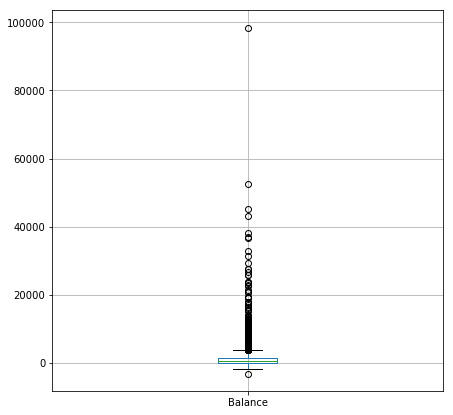

In [8]:
df_train.boxplot(column='Balance',figsize=(7,7))

This boxplot helps us understand a little bit how ununified is the distribution of balances. While the mean is the 3rd percentile, the variance is high, and can teach us about the population which the companies prefer to target. Higher balance is naturally preferred. There is a clear outlier with a balance around the 100,000$. Let's explore this specific obeservation a little deeper

In [9]:
mask =df_train['Balance']>60000
df_train[mask]

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
1742,1743,59,management,married,tertiary,0,98417,0,0,telephone,20,nov,5,-1,0,NaN,10:51:42,10:54:07,0


OK so how different this observation from the other? Let's check similar observation to decide

In [10]:
mask1=df_train['Age']>50
mask2=df_train['Marital']=='married'
mask3=df_train['Education']=='tertiary'
df_outlier_check=df_train[mask1 & mask2 &mask3]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BA73B38>]], dtype=object)

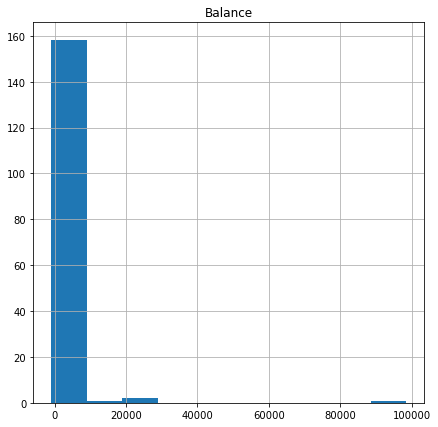

In [11]:
%matplotlib inline
df_outlier_check.hist(column='Balance',figsize=(7,7),bins=10) #let's see among this specific portion what are the common values

In [12]:
df_outlier_check['Balance'].describe()

count      162.000000
mean      2489.456790
std       8134.584629
min       -970.000000
25%        270.500000
50%        830.000000
75%       2403.500000
max      98417.000000
Name: Balance, dtype: float64

So it looks like our observation is far from representing the population with the same characteristics and is rarely the type of client our company usually addresses. Conclusion - this observation should be removed.

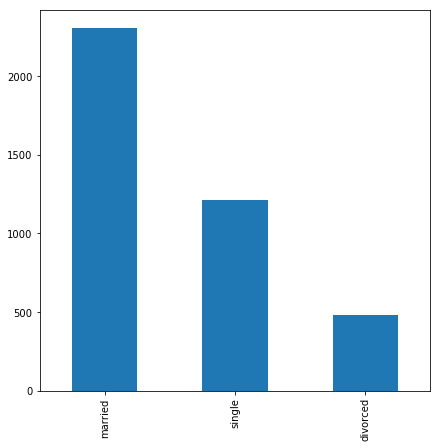

In [13]:
# Let's plot the 
df_train['Marital'].value_counts().plot(kind='bar',figsize=(7,7))


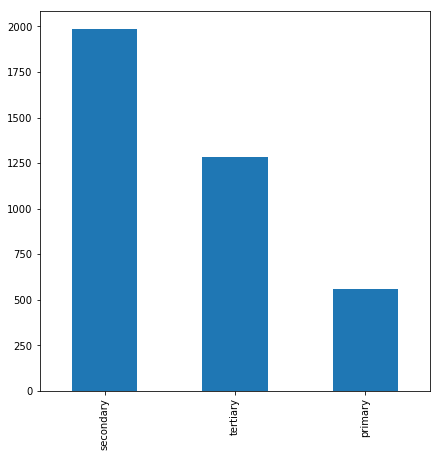

In [14]:
df_train['Education'].value_counts().plot(kind='bar',figsize=(7,7))

Let's see what are the missing values 

In [15]:
df_train.isnull().any()

Id                  False
Age                 False
Job                  True
Marital             False
Education            True
Default             False
Balance             False
HHInsurance         False
CarLoan             False
Communication        True
LastContactDay      False
LastContactMonth    False
NoOfContacts        False
DaysPassed          False
PrevAttempts        False
Outcome              True
CallStart           False
CallEnd             False
CarInsurance        False
dtype: bool

In [16]:
nullNames=['Job','Education','Communication','Outcome'] #These are the collums that have missing values

In [17]:
for item in nullNames:
   print(df_train[item].value_counts(dropna=False))

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
NaN               19
Name: Job, dtype: int64
secondary    1988
tertiary     1282
primary       561
NaN           169
Name: Education, dtype: int64
cellular     2831
NaN           902
telephone     267
Name: Communication, dtype: int64
NaN        3042
failure     437
success     326
other       195
Name: Outcome, dtype: int64


By looking at this analysis, we can learn that the column "Communication" has over 75% null values. Hence, it can't contribute to our model and therefor should be removed. Let's see the distribution of null values in the test dataset

In [18]:
def selectColumns(df,irrelevants): #this function will give us the dataframe with our selected features
    names=list(df.columns)
    for item in irrelevants:
        names.remove(item)
    return df[names]

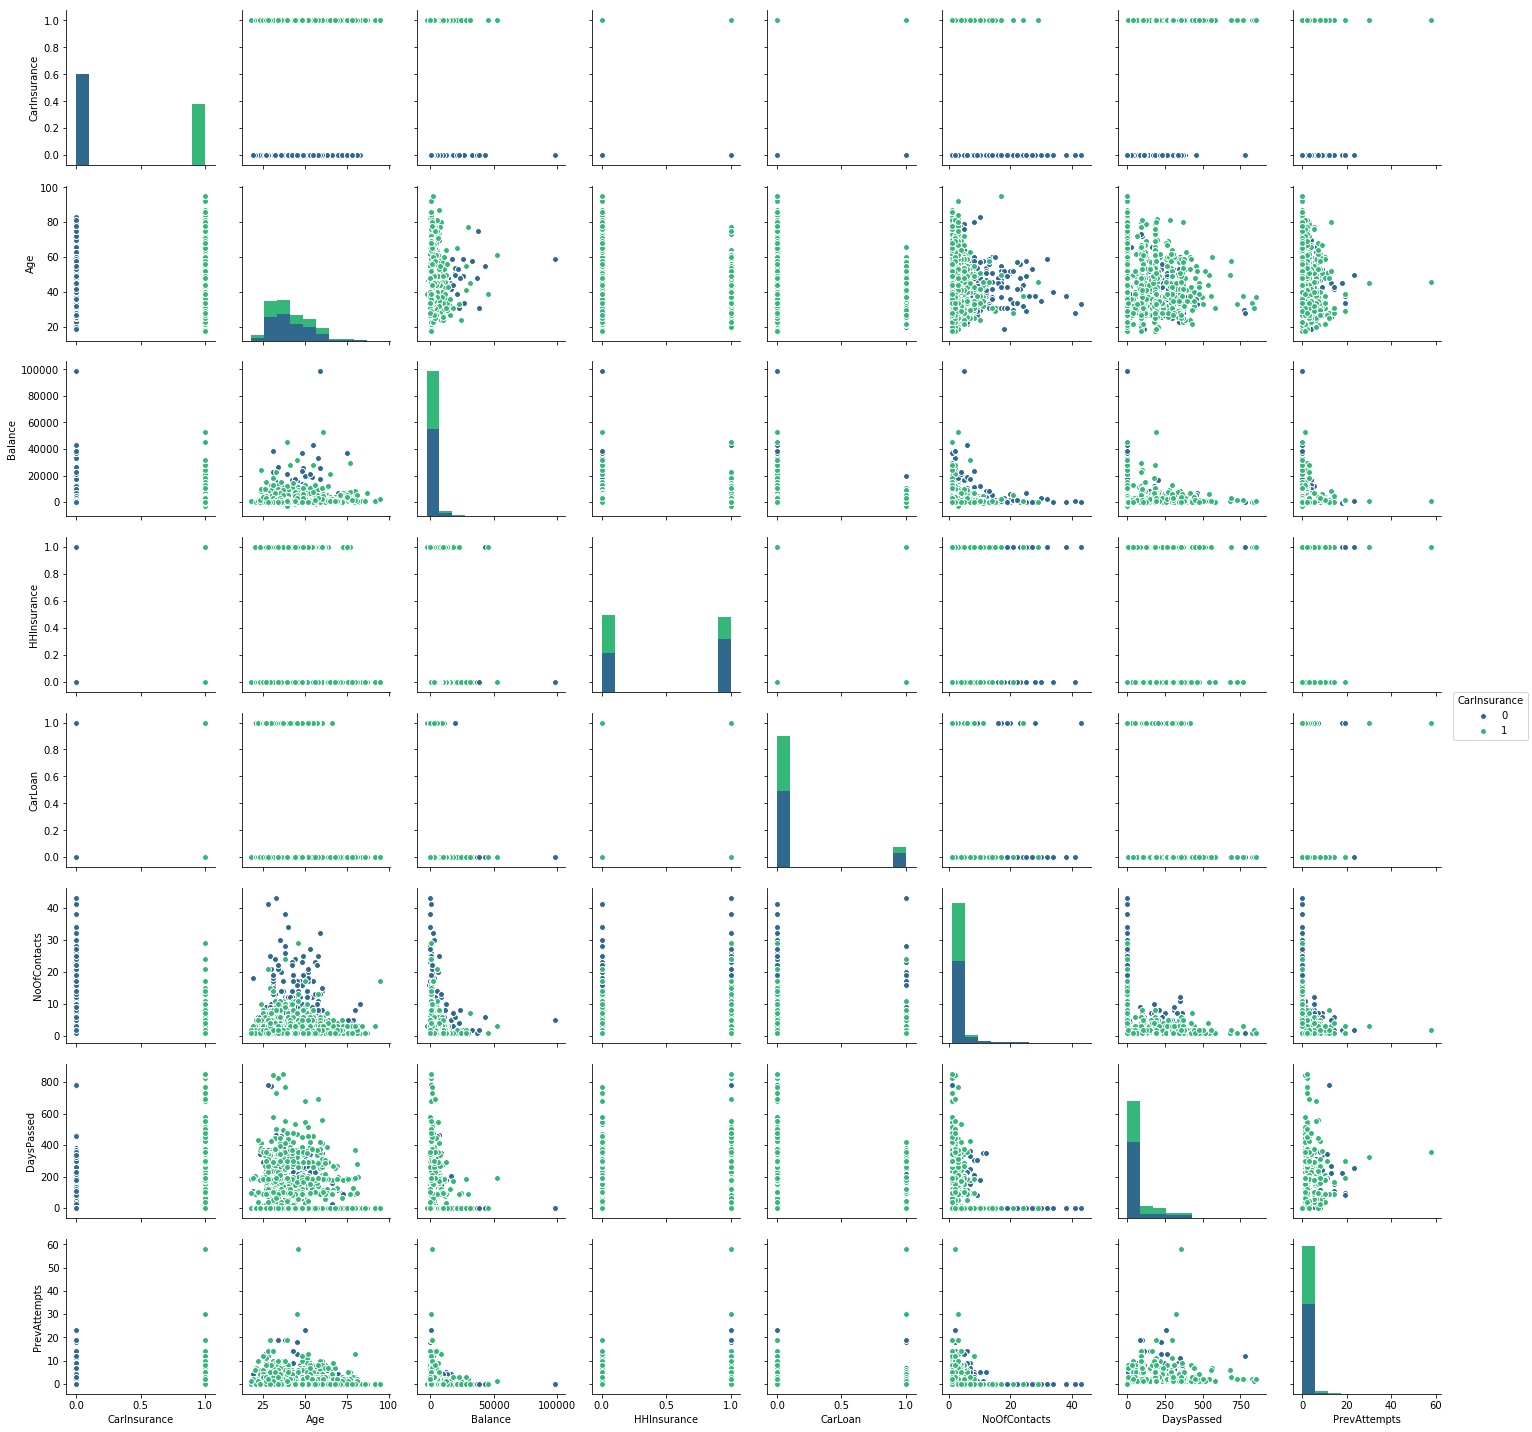

In [19]:
# Let's see what can we learn about the data from a pairplot
imp_feats = ['CarInsurance','Age','Balance','HHInsurance', 'CarLoan','NoOfContacts','DaysPassed','PrevAttempts']
sns.pairplot(df_train[imp_feats],hue='CarInsurance',palette='viridis',size=2.5)
plt.show()

Interesting! Let's draw some conclusions from this plot:
•	The distribution of the insurance buyers is mostly aligned with the general distribution, with a slight likelihood of purchasing insurance in higher ages
•	The higher the balance, the higher the chances to buy insurance
•	Those who don't have a car loan are more likely to buy insurance
•	The lower the previous contacts number is, the higher the chances to make the client to buy the insurance
•	It is more likely to buy car insurance if a customer doesn't have house hold insurance



# Feature Engineering

While most of the important features are categorical, we may want to use the call duration for further analysis. In order to do this we will create a new column for call duration

In [20]:
def timediff(a,b): # Creating a new function that will return the time difference in seconds
    FMT = '%H:%M:%S'
    x=datetime.strptime(a,FMT)
    y =datetime.strptime(b,FMT)
    result=(x-y).seconds
    return (result)

In [21]:
def callDuration(df): # This function will create the NP array that will populate the time differences
    temp_array=np.array([])
    for a,b in zip(df['CallEnd'],df['CallStart']):
        time_diff=timediff(a,b)
        temp_array=np.append(temp_array,time_diff)
    return temp_array
    

In [22]:
def getWeekDay(month,day,gap): # we assume that the year is 2016
    date = datetime(year=2016, month = int(month), day = int(day))
    date+=timedelta(days = int(gap))
    return date.weekday()

While the call duration maybe nice to have, it is nothing that the call center manager can predict before the call starts. Does it mean data leakage? Not necessarily. We may not use the data for call duration, but what we can do, is to map the time of the day in which the call was conducted, and see how this feature effects our model.

In [23]:
def convertHours(series): # This function converts the hour to a numeric value
    FMT = '%H:%M:%S'
    temp_array=np.array([])
    for value in series:
        x=datetime.strptime(value,FMT).hour
        y=datetime.strptime(value,FMT).minute/60
        temp_array=np.append(temp_array,x+y)
    return temp_array

In [24]:
df_train['CallStartNum']=pd.Series(convertHours(df_train['CallStart'])) #Adding to training set

In [25]:
df_test['CallStartNum']=pd.Series(convertHours(df_test['CallStart'])) #Adding to test set

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010214710>]], dtype=object)

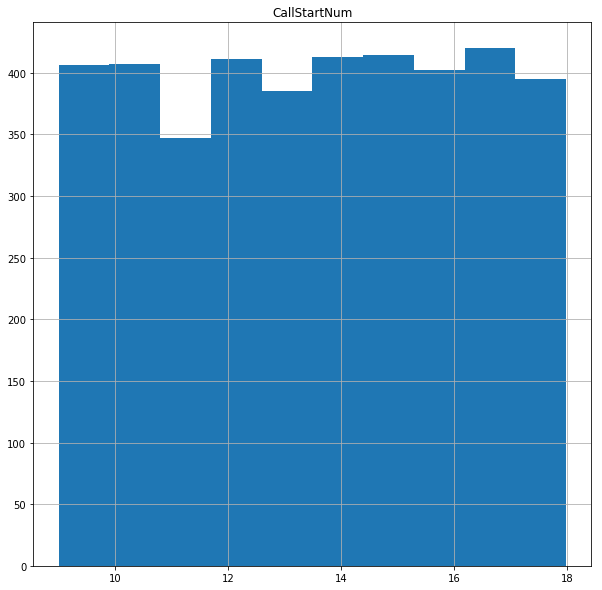

In [26]:
df_train.hist(column='CallStartNum',figsize=(10,10),bins=10)

So we now see that our calls were conducted from 9am-6pm which are the usual business hours, and in good proximity, they are pretty uniformly distributed. We will split them into three categories: Morning, Mid-day, Afternoon

In [27]:
# we'll discretize the call time where 1= Morning, 2=Mid day and 3=afternoon
df_train.loc[(df_train['CallStartNum']>=9) & (df_train['CallStartNum']<12),'CallTime'] = 1
df_train.loc[(df_train['CallStartNum']>=12) & (df_train['CallStartNum']<15),'CallTime'] = 2
df_train.loc[(df_train['CallStartNum']>=15) ,'CallTime'] =3

In [28]:
# we'll do the same for the test set
df_test.loc[(df_test['CallStartNum']>=9) & (df_test['CallStartNum']<12),'CallTime'] = 1
df_test.loc[(df_test['CallStartNum']>=12) & (df_test['CallStartNum']<15),'CallTime'] = 2
df_test.loc[(df_test['CallStartNum']>=15) ,'CallTime'] =3

In [29]:
df_train['DaysPassed'].replace(-1,0,inplace=True)#removing the -1 values

In [30]:
df_test['DaysPassed'].replace(-1,0,inplace=True)#removing the -1 values

In [31]:
# Let's convert the months to their corresponding numbers
df_train['LastContactMonth']= df_train['LastContactMonth'].apply(lambda x: list(calendar.month_abbr).index(x[0].upper()+x[1:]))
df_test['LastContactMonth'] = df_test['LastContactMonth'].apply(lambda x: list(calendar.month_abbr).index(x[0].upper()+x[1:]))

In [32]:
df_train['CallDuration'] = pd.Series(callDuration(df_train))

In [33]:
df_train['Weekday'] =df_train[['LastContactMonth','LastContactDay','DaysPassed']].apply(lambda x: getWeekDay(*x), axis=1)

In [34]:
df_train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,...,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance,CallStartNum,CallTime,CallDuration,Weekday
0,1,32,management,single,tertiary,0,1218,1,0,telephone,...,0,0,NaN,13:45:20,13:46:30,0,13.750000,2.0,70.0,3
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,...,0,0,NaN,14:49:03,14:52:08,0,14.816667,2.0,185.0,3
2,3,29,management,single,tertiary,0,637,1,0,cellular,...,119,1,failure,16:30:24,16:36:04,1,16.500000,3.0,340.0,4
3,4,25,student,single,primary,0,373,1,0,cellular,...,0,0,NaN,12:06:43,12:20:22,1,12.100000,2.0,819.0,2
4,5,30,management,married,tertiary,0,2694,0,0,cellular,...,0,0,NaN,14:35:44,14:38:56,0,14.583333,2.0,192.0,4


In [35]:
df_train.Education.value_counts(dropna=False)

secondary    1988
tertiary     1282
primary       561
NaN           169
Name: Education, dtype: int64

In [36]:
df_train.Job.value_counts(dropna=False)

management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
NaN               19
Name: Job, dtype: int64

# Filling missing values

So we cleaned features with less information, and now it's time to fill in the values of the 2 rows remaining for the features selection. Since we are talking about categorical values, we will go for the mode in filling these fields

In [37]:
mode_edu_train=str(df_train['Education'].mode().iloc[0])
mode_job_train=str(df_train['Job'].mode().iloc[0])
mode_edu_test=str(df_test['Education'].mode().iloc[0])
mode_job_test=str(df_test['Job'].mode().iloc[0])

In [38]:
df_train.Education.replace(np.NaN,mode_edu_train,inplace=True)
df_train.Job.replace(np.NaN,mode_job_train,inplace=True)
df_test.Education.replace(np.NaN,mode_edu_test,inplace=True)
df_test.Job.replace(np.NaN,mode_job_test,inplace=True)

So it's time to prepare our datasets for the model implementation stage.

In [39]:
df_train = df_train.drop(df_train[df_train.Id==1742].Id) #let's remove the outlier

In [40]:
irrelevants=['Id','Communication','LastContactDay','LastContactMonth','Outcome','CallStart','CallEnd','CallStartNum']

In [41]:
df_train=selectColumns(df_train,irrelevants)

In [42]:
df_test=selectColumns(df_test,irrelevants)

In [43]:
df_train.isnull().sum()

Age             0
Job             0
Marital         0
Education       0
Default         0
Balance         0
HHInsurance     0
CarLoan         0
NoOfContacts    0
DaysPassed      0
PrevAttempts    0
CarInsurance    0
CallTime        0
CallDuration    0
Weekday         0
dtype: int64

In [44]:
df_train.shape

(3999, 15)

Great! we have a clean data set! last thing we need is to get dummy variables for our categorical values!


In [45]:
df_train=pd.get_dummies(df_train,columns=['Education','Job','Marital'])

In [46]:
df_train.head()

,Age,Default,Balance,HHInsurance,CarLoan,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance,CallTime,...,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,Job_unemployed,Marital_divorced,Marital_married,Marital_single
0,32,0,1218,1,0,2,0,0,0,2.0,...,1,0,0,0,0,0,0,0,0,1
1,32,0,1156,1,0,5,0,0,0,2.0,...,0,0,0,0,0,0,0,0,1,0
2,29,0,637,1,0,1,119,1,1,3.0,...,1,0,0,0,0,0,0,0,0,1
3,25,0,373,1,0,2,0,0,1,2.0,...,0,0,0,0,1,0,0,0,0,1
4,30,0,2694,0,0,1,0,0,0,2.0,...,1,0,0,0,0,0,0,0,1,0


# Modeling

Since our test set has no values, we will not use it at this stage and will work on train and test set from within the train set

In [47]:
y=df_train['CarInsurance'] #Scaling the data,Splitting the training set into train and test set 
X=df_train.drop('CarInsurance',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=324)
X = StandardScaler().fit_transform(X)

In [48]:
# Optimizing each model
def fit_best_model(model,parameters,X_train,y_train):
    clf = GridSearchCV(estimator = model,param_grid = parameters,cv=5, scoring="accuracy", n_jobs= 1)
    clf.fit(X_train,y_train)
    print ("--------------The model's accuracy is: %.5f " % clf.best_score_)
    print ("\n----------------The model's best parameters are:  " )
    print (clf.best_params_)
    return clf.best_estimator_

In [49]:
# Code taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def confusionMatrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Issuing the image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "Blue")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Success','Failure']


In [50]:
# In this function, we sum all other actions, train the model, fit it, and measure its accuracy 
def predictions(estimator,X_train,X_test,y_train,y_test, feature_imp=False):
    model=estimator.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    confusionMatrix(cm, classes=class_names, title='Confusion matrix')
    print("----------------The Prediction's accuracy is: %.5f "  %accuracy_score(y_test,y_pred) )
     # feature importance 
    if feature_imp:
        
        feat_imp = pd.Series(estimator.feature_importances_,index=X_train.columns)
        feat_imp = feat_imp.nlargest(15).sort_values()
        plt.figure()
        feat_imp.plot(kind="barh",figsize=(10,10),title="Most Important Features")

#  K- Nearest Neighbors

--------------The model's accuracy is: 0.76125 

----------------The model's best parameters are:  
{'n_neighbors': 7, 'weights': 'uniform', 'p': 1}
----------------The Prediction's accuracy is: 0.77000 


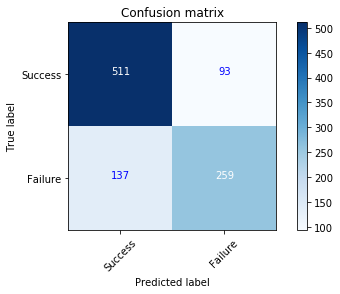

In [51]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5,6,7], 
              'p':[1,2],
              'weights':['uniform','distance']}
clf =fit_best_model(knn,parameters,X_train,y_train)
predictions(clf,X_train,X_test,y_train,y_test)

# Logistic regression

--------------The model's accuracy is: 0.78660 

----------------The model's best parameters are:  
{'penalty': 'l1', 'C': 1}
----------------The Prediction's accuracy is: 0.78600 


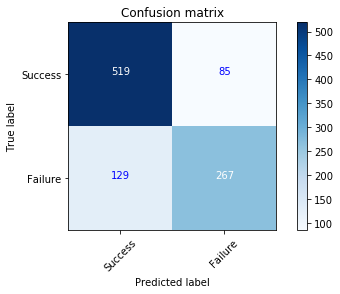

In [52]:
lg = LogisticRegression(random_state=3)
parameters = {'C':[0.8,0.9,1], 
              'penalty':['l1','l2']}
clf_lg = fit_best_model(lg,parameters,X_train,y_train)
predictions(clf_lg,X_train,X_test,y_train,y_test)

# Random forest

--------------The model's accuracy is: 0.81927 

----------------The model's best parameters are:  
{'n_estimators': 100, 'max_depth': 10, 'max_features': 13, 'min_samples_split': 11}
----------------The Prediction's accuracy is: 0.82700 


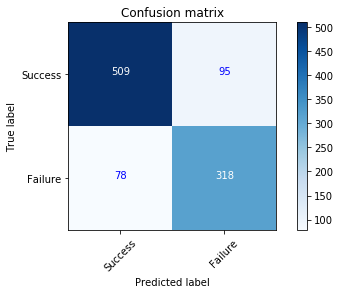

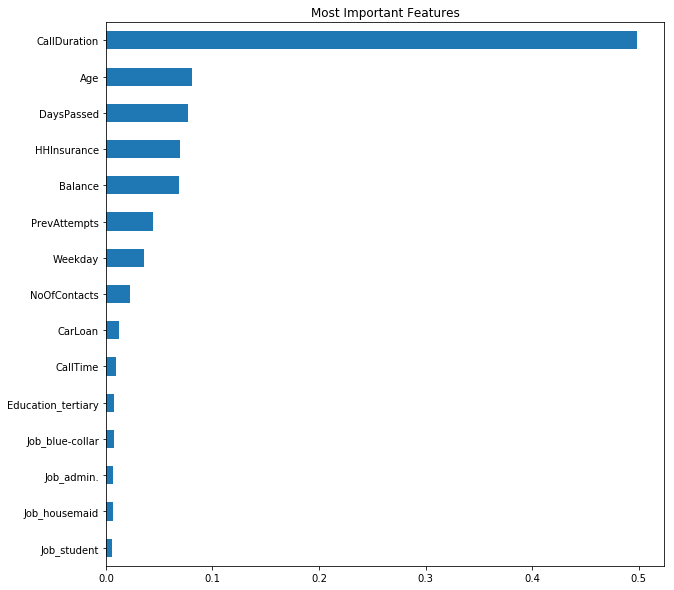

In [53]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
            'max_depth':[10],
            'max_features':[13,14],
            'min_samples_split':[11]}
clf_rf = fit_best_model(rf,parameters,X_train,y_train)
predictions(clf_rf,X_train,X_test,y_train,y_test,feature_imp=True)

# Decision Tree classifier

--------------The model's accuracy is: 0.80393 

----------------The model's best parameters are:  
{}
----------------The Prediction's accuracy is: 0.82700 


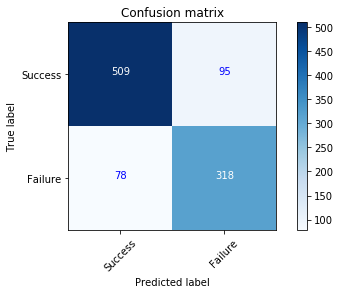

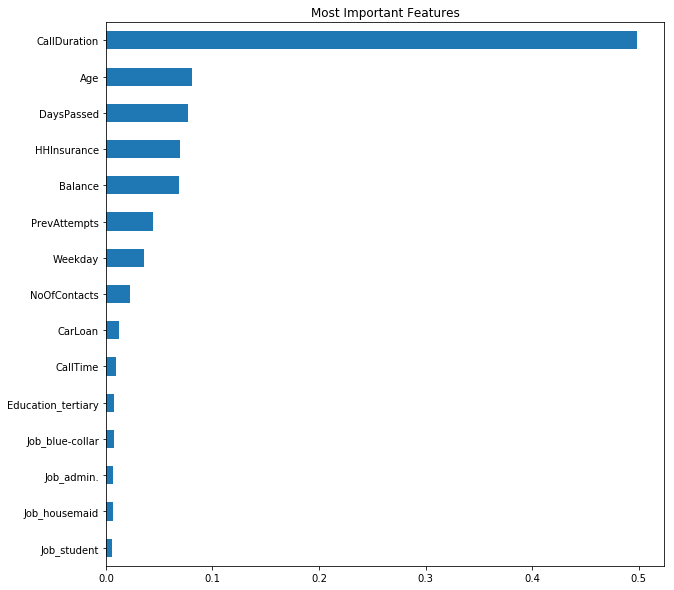

In [ ]:
dt =  DecisionTreeClassifier(max_leaf_nodes=15)
parameters = {}
clf_dt=  fit_best_model(dt,parameters,X_train,y_train)
predictions(clf_rf,X_train,X_test,y_train,y_test,feature_imp=True)

 # SVM

In [ ]:
svc = SVC(probability=True, random_state=3)
parameters =[
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
clf_svc = fit_best_model(svc,parameters,X_train,y_train)
predictions(clf_rf,X_train,X_test,y_train,y_test)